# Traffic Sign Classification Using Classical Digital Image Processing Techniques
Aiza Ali (22i-0612) | Malaika Saleem (22i-0509) | Hafsa Siddiqua (22i-0542) | Uriba Parveen (22i-0465) 

## Importing Libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import PIL
from PIL import Image

## Dataset Loading

### Chosen Classes
- Class 0 : Speed Limit 20 (prohibitory)
- Class 9:  No Overtaking (prohibitory)
- Class 12: Priority Road (other)
- Class 14: Stop (other)
- Class 17: No Entry (other)
- Class 27: Pedestrian Crossing (danger)
- Class 33: Go Right (mandatory)
- Class 40: Roundabout (mandatory)


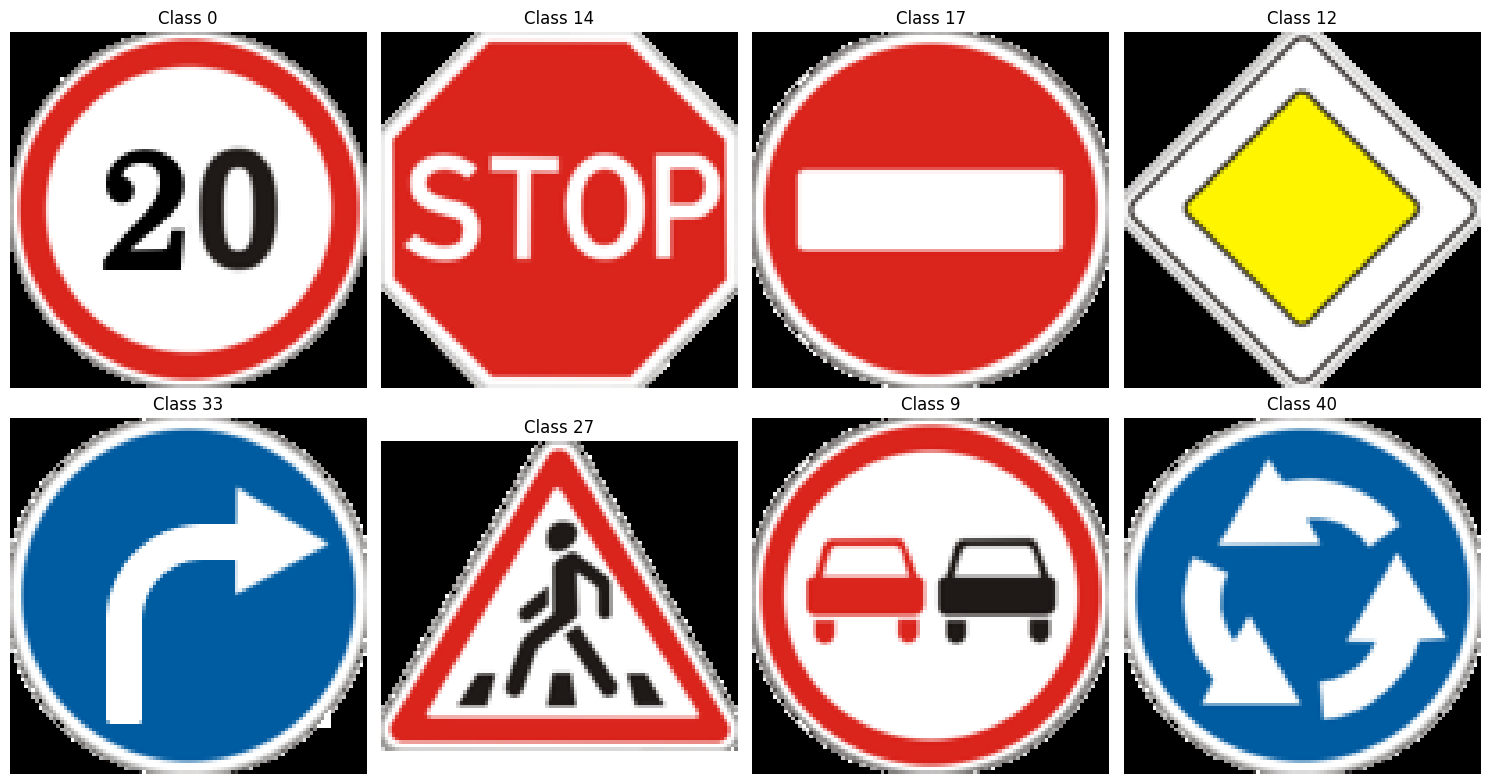

In [2]:
# Define the path to the Meta folder
meta_path = 'archive/Meta'
selected_classes = [0, 14, 17, 12, 33, 27, 9, 40]

# Number of rows and columns for the grid
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

# Iterate through the selected classes
for idx, class_id in enumerate(selected_classes):
    image_filename = f'{class_id}.png'
    image_path = os.path.join(meta_path, image_filename)

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is not None:
        # Convert the image from BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image in the grid
        axes[idx].imshow(image_rgb)
        axes[idx].set_title(f'Class {class_id}')
        axes[idx].axis('off')
    else:
        axes[idx].set_title(f'Class {class_id} not found')
        axes[idx].axis('off')

# Hide any unused subplots
for ax in axes[len(selected_classes):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Define the path to your dataset
dataset_path = "archive/"
train_path = os.path.join(dataset_path, "train")
meta_path = os.path.join(dataset_path, "meta")
test_path = os.path.join(dataset_path, "test")

# Read the CSV files
meta_df = pd.read_csv(os.path.join("archive/Meta.csv"))
train_df = pd.read_csv(os.path.join ("archive/Train.csv"))
test_df = pd.read_csv(os.path.join( "archive/Test.csv"))

# Define the selected class IDs (based on our previous discussion)
selected_classes = [0, 14, 17, 12, 33, 27, 9, 40]

# Filter the train DataFrame to include only the selected classes
filtered_train_df = train_df[train_df["ClassId"].isin(selected_classes)]

# Create a dictionary to store the loaded images and their class IDs
loaded_images = {}

# Load images for the selected classes
for index, row in filtered_train_df.iterrows():
    image_path = os.path.join(train_path, row["Path"])
    class_id = row["ClassId"]
    
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Store the image and class ID in the dictionary
    if class_id not in loaded_images:
        loaded_images[class_id] = []
    loaded_images[class_id].append(image)

print(train_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [6]:
train_df.columns
np.unique(train_df.ClassId)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [4]:
# Save DataFrames to CSV files
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
meta_df.to_csv('meta_data.csv', index=False)

print("DataFrames have been saved to CSV files.")

DataFrames have been saved to CSV files.


### Separate All Selected Classes

In [7]:
# Create separate DataFrames for the 8 selected classes
# Combine all class-specific DataFrames into one DataFrame
combined_df = pd.concat([
    train_df[train_df['ClassId'] == 0],
    train_df[train_df['ClassId'] == 14],
    train_df[train_df['ClassId'] == 17],
    train_df[train_df['ClassId'] == 12],
    train_df[train_df['ClassId'] == 33],
    train_df[train_df['ClassId'] == 27],
    train_df[train_df['ClassId'] == 9],
    train_df[train_df['ClassId'] == 40]
], ignore_index=True)

# Example: Display the first few rows of the combined DataFrame

combined_df.to_csv('combined_df.csv', index=False)

print('Combined DataFrame:')
combined_df.head()


# # Example: Display the first few rows of one of the DataFrames
# print('Class 0 DataFrame:')
# train_class_0_df.tail()

Combined DataFrame:


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,29,30,5,6,24,25,0,Train/0/00000_00000_00000.png
1,30,30,5,5,25,25,0,Train/0/00000_00000_00001.png
2,30,30,5,5,25,25,0,Train/0/00000_00000_00002.png
3,31,31,5,5,26,26,0,Train/0/00000_00000_00003.png
4,30,32,5,6,25,26,0,Train/0/00000_00000_00004.png


In [8]:
np.unique(combined_df.ClassId)

array([ 0,  9, 12, 14, 17, 27, 33, 40], dtype=int64)

## Preprocessing and Filtering 

 ### Mean Filter (3×3)
 (Brief Description of how it works)

In [42]:
def mean_filter(image):
    # Convert image to float for accurate calculations
    image = image.astype(np.float32) / 255.0
    
    # Define a 3x3 mean kernel
    kernel = np.ones((3, 3), dtype=np.float32) / 9.0
    
    # Pad the image to handle borders
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='reflect')
    
    # Apply the mean filter
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                filtered_image[i, j, c] = np.sum(padded_image[i:i+3, j:j+3, c] * kernel)
    
    # Convert back to uint8
    return (filtered_image * 255).astype(np.uint8)

### Gaussian Filter (with standard deviation) 
(Brief Description of how it works)

In [43]:
def gaussian_filter(image, sigma=1.0):
    # Convert image to float
    image = image.astype(np.float32) / 255.0
    
    # Define a 3x3 Gaussian kernel
    size = 3
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)
    
    # Pad the image
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='reflect')
    
    # Apply the Gaussian filter
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                filtered_image[i, j, c] = np.sum(padded_image[i:i+3, j:j+3, c] * kernel)
    
    # Convert back to uint8
    return (filtered_image * 255).astype(np.uint8)

### Median Filter
(Brief Description of how it works)

In [44]:
def median_filter(image):
    # Pad the image
    padded_image = np.pad(image, ((1, 1), (1, 1), (0, 0)), mode='reflect')
    
    # Apply the median filter
    filtered_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                patch = padded_image[i:i+3, j:j+3, c]
                filtered_image[i, j, c] = np.median(patch)
    
    return filtered_image.astype(np.uint8)

 ### Adaptive Median Filter
 (Brief Description of how it works)

In [45]:
def adaptive_median_filter(image, max_size=7):
    # Pad the image with max_size//2 to handle the largest window
    pad_size = max_size // 2
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
    
    filtered_image = np.copy(image).astype(np.uint8)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for c in range(image.shape[2]):
                # Start with a small window and increase up to max_size
                for window_size in range(3, max_size + 1, 2):
                    half_size = window_size // 2
                    patch = padded_image[i:i+window_size, j:j+window_size, c]
                    
                    # Compute median, min, and max of the patch
                    med = np.median(patch)
                    mn = np.min(patch)
                    mx = np.max(patch)
                    
                    # If the center pixel is an impulse noise, replace it with the median
                    if not (mn < padded_image[i+half_size, j+half_size, c] < mx):
                        filtered_image[i, j, c] = med
                        break  # No need to check larger windows
    
    return filtered_image

### Unsharp Masking and/or High-Boost Filtering
(Brief Description of how it works)

In [46]:
def unsharp_masking(image, sigma=1.0, strength=1.0):
    # Convert image to float
    image = image.astype(np.float32) / 255.0
    
    # Apply Gaussian blur
    blurred = gaussian_filter((image * 255).astype(np.uint8), sigma).astype(np.float32) / 255.0
    
    # Compute the high-pass image
    high_pass = image - blurred
    
    # Combine the original image with the high-pass image
    sharpened = image + strength * high_pass
    
    # Clip values to [0, 1] and convert back to uint8
    sharpened = np.clip(sharpened, 0, 1)
    return (sharpened * 255).astype(np.uint8)

### Filter Checkpoint

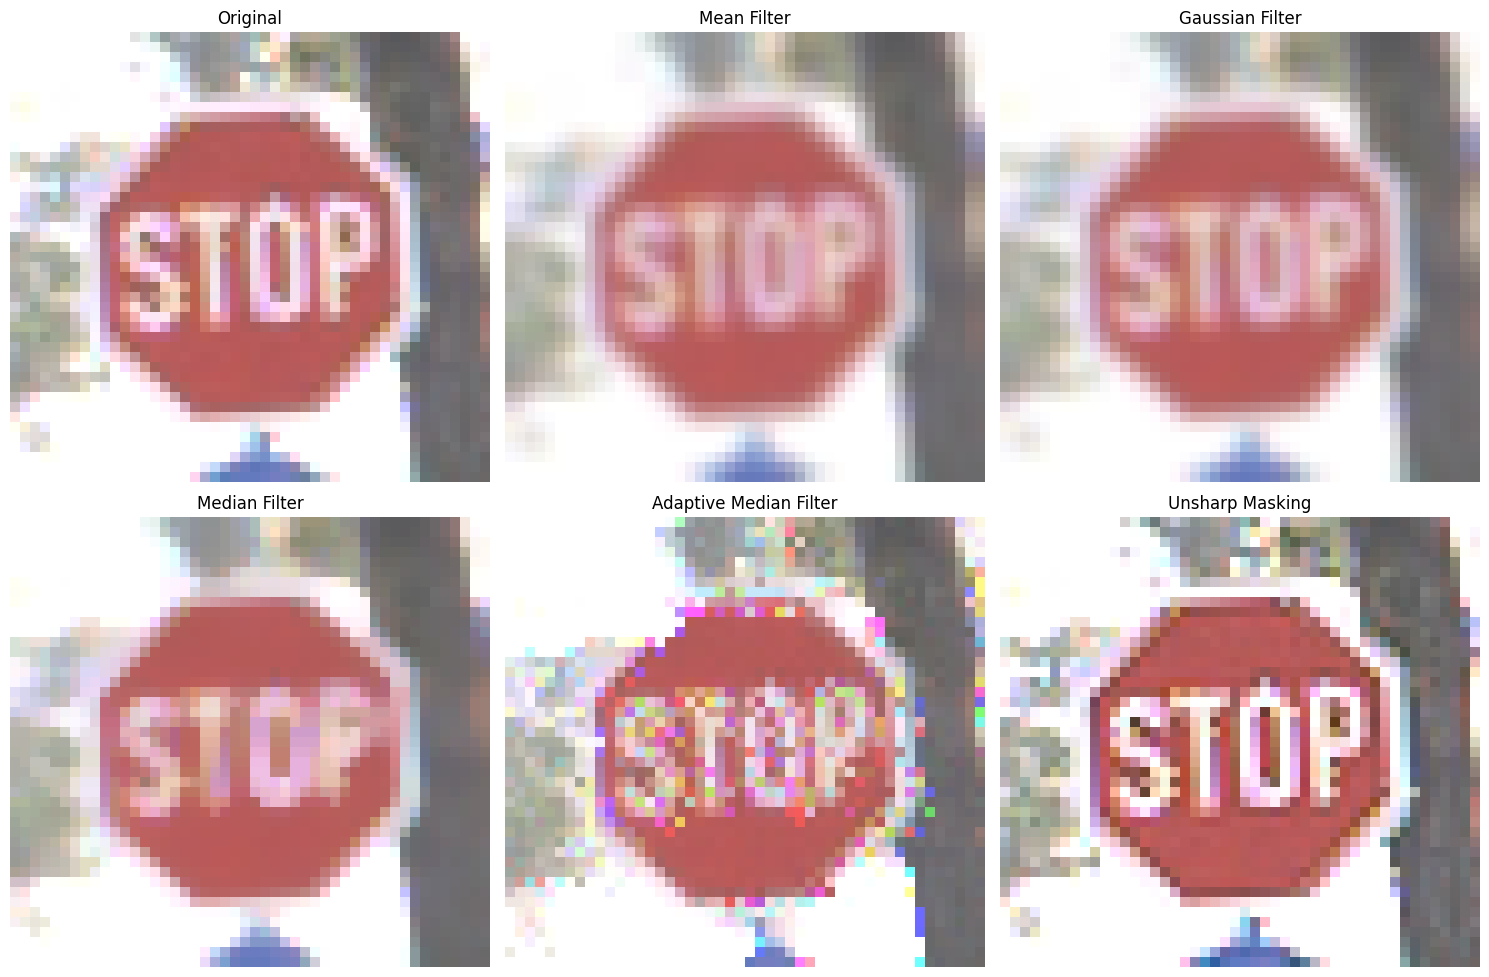

In [47]:
import matplotlib.pyplot as plt

# Select an image from class 0 (example: first image in the loaded_images for class 0)

sample_image = train_class_14_df.iloc[0]["Path"]
sample_image_path = os.path.join(dataset_path, sample_image)

# Load the image using OpenCV
sample_image_array = cv2.imread(sample_image_path)

# Apply filters to the sample image
mean_filtered = mean_filter(sample_image_array)
gaussian_filtered = gaussian_filter(sample_image_array, sigma=1.0)
median_filtered = median_filter(sample_image_array)
adaptive_median_filtered = adaptive_median_filter(sample_image_array)
unsharp_filtered = unsharp_masking(sample_image_array, sigma=1.0, strength=1.0)

# Create a list of images and their titles
images = [
    ("Original", sample_image_array),
    ("Mean Filter", mean_filtered),
    ("Gaussian Filter", gaussian_filtered),
    ("Median Filter", median_filtered),
    ("Adaptive Median Filter", adaptive_median_filtered),
    ("Unsharp Masking", unsharp_filtered)
]

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (title, img) in zip(axes, images):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

##  Color Space Conversion and Segmentation

### Convert RGB images to HSV color space manually or using PIL.

#### Manual Conversion

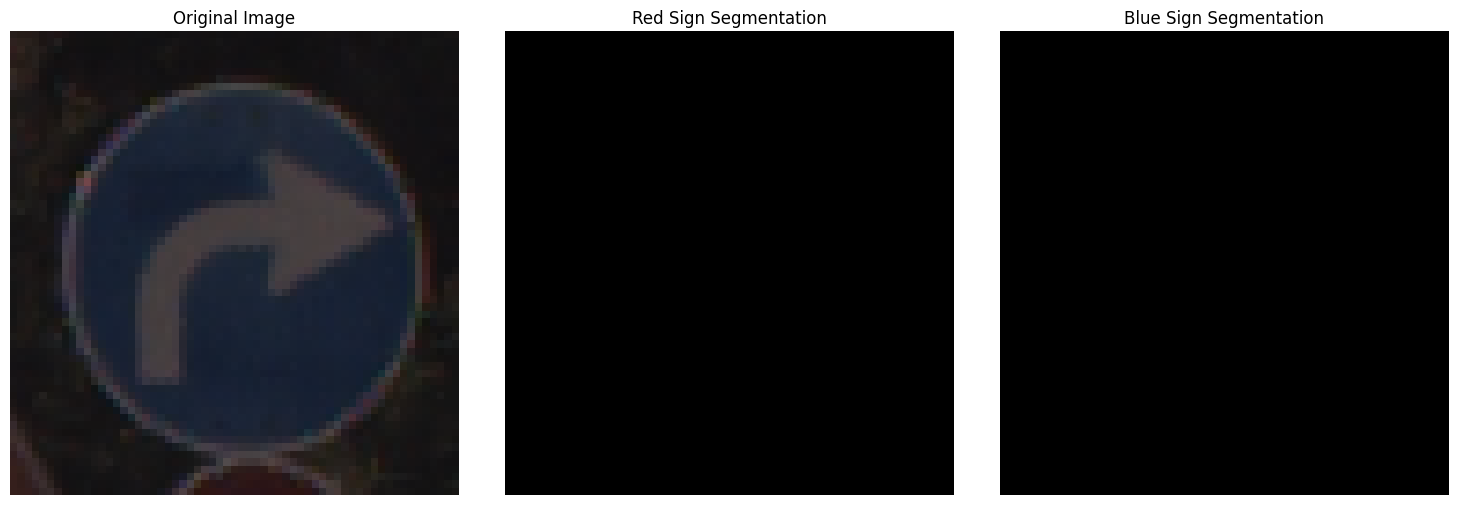

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def rgb_to_hsv(rgb):
    r, g, b = rgb[0] / 255.0, rgb[1] / 255.0, rgb[2] / 255.0
    c_max = max(r, g, b)
    c_min = min(r, g, b)
    delta = c_max - c_min

    # Hue
    if delta == 0:
        h = 0
    elif c_max == r:
        h = (60 * ((g - b) / delta) + 360) % 360
    elif c_max == g:
        h = (60 * ((b - r) / delta) + 120) % 360
    else:
        h = (60 * ((r - g) / delta) + 240) % 360

    # Saturation
    s = 0 if c_max == 0 else (delta / c_max)

    # Value
    v = c_max

    return np.array([h, s * 100, v * 100])

def segment_hsv(image):
    height, width, _ = image.shape
    red_segment = np.zeros_like(image)
    blue_segment = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            hsv_pixel = rgb_to_hsv(image[i, j])
            h, s, v = hsv_pixel

            s = round(s)
            v = round(v)

            #if ((0 <= h <= 15 or 165 <= h <= 180) and s == 100 and v == 80):
            #    red_segment[i, j] = [255, 0, 0]  # RGB Red
            #elif (100 <= h <= 130 and s == 100 and v == 80):
            #    blue_segment[i, j] = [0, 0, 255]  # RGB Blue
            # Use ranges instead of exact values
            if ((0 <= h <= 20 or 160 <= h <= 180) and s > 50  and v > 40):
                red_segment[i, j] = [255, 0, 0]  # Red in RGB
            elif ((200 <= h <= 240) or (100 <= h <= 130)) and (s >= 50) and (v >= 40):
                blue_segment[i, j] = [0, 0, 255]  # Blue in RGB

    return red_segment, blue_segment

# Load and convert image
image_path = sample_image_path
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

image_path = "archive/Train/33/00033_00000_00020.png"
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


# Segment
red_segment, blue_segment = segment_hsv(image_rgb)

# Display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(red_segment)
axes[1].set_title('Red Sign Segmentation')
axes[1].axis('off')

axes[2].imshow(blue_segment)
axes[2].set_title('Blue Sign Segmentation')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### Post Processing
- Binary mask thresholding
- Morphological operations (erosion, dilation, opening)
- Noise removal via connected component filtering (area threshold)
- Hole filling

In [49]:
# Post-processing functions
def binary_thresholding(mask, threshold=0.5):
    return np.where(mask > threshold, 1, 0)

def erosion(binary_mask, structure=None):
    if structure is None:
        structure = np.ones((3, 3))  # Default 3x3 structuring element
    output = np.zeros_like(binary_mask)
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)

    for i in range(1, binary_mask.shape[0] - 1):
        for j in range(1, binary_mask.shape[1] - 1):
            region = padded_mask[i-1:i+2, j-1:j+2]
            output[i, j] = np.min(region * structure)

    return output

def dilation(binary_mask, structure=None):
    if structure is None:
        structure = np.ones((3, 3))  # Default 3x3 structuring element
    output = np.zeros_like(binary_mask)
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)

    for i in range(1, binary_mask.shape[0] - 1):
        for j in range(1, binary_mask.shape[1] - 1):
            region = padded_mask[i-1:i+2, j-1:j+2]
            output[i, j] = np.max(region * structure)

    return output

def opening(binary_mask, structure=None):
    eroded = erosion(binary_mask, structure)
    return dilation(eroded, structure)

def label_connected_components(binary_mask):
    labels = np.zeros_like(binary_mask)
    label = 1

    for i in range(1, binary_mask.shape[0] - 1):
        for j in range(1, binary_mask.shape[1] - 1):
            if binary_mask[i, j] == 1 and labels[i, j] == 0:
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    if labels[x, y] == 0:
                        labels[x, y] = label
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if 0 <= x + dx < binary_mask.shape[0] and 0 <= y + dy < binary_mask.shape[1]:
                                    if binary_mask[x + dx, y + dy] == 1 and labels[x + dx, y + dy] == 0:
                                        stack.append((x + dx, y + dy))
                label += 1

    return labels, label - 1

def remove_small_components(labels, min_area=100):
    output = np.zeros_like(labels)
    num_labels = np.max(labels)

    for label in range(1, num_labels + 1):
        area = np.sum(labels == label)
        if area >= min_area:
            output[labels == label] = label
    return output

def fill_holes(binary_mask):
    dilated = dilation(binary_mask, structure=np.ones((3, 3)))
    filled = erosion(dilated, structure=np.ones((3, 3)))
    return filled

def post_process_mask(mask, min_area=100):
    binary_mask = binary_thresholding(mask)
    eroded_mask = erosion(binary_mask)
    dilated_mask = dilation(binary_mask)
    opened_mask = opening(binary_mask)

    labels, num_labels = label_connected_components(opened_mask)
    cleaned_mask = remove_small_components(labels, min_area)

    filled_mask = fill_holes(cleaned_mask)

    return filled_mask




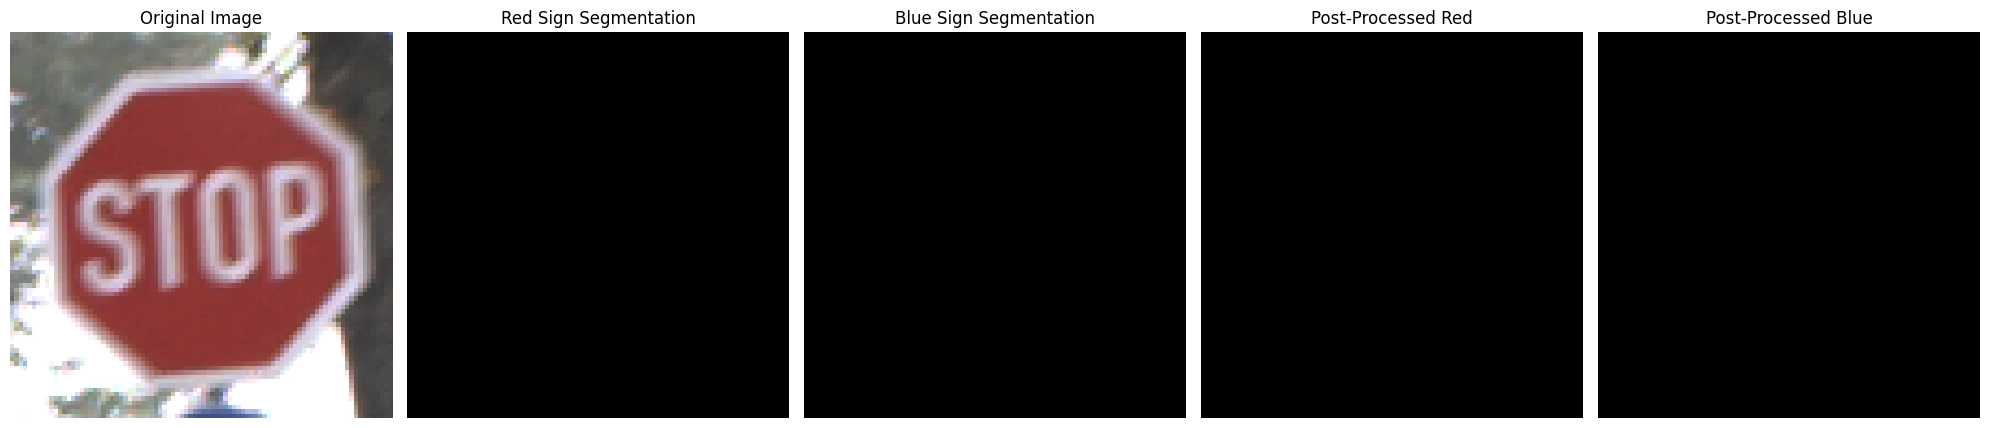

In [50]:
# Load and convert image
image_path = "archive/Train/14/00014_00000_00020.png"
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Segment
red_segment, blue_segment = segment_hsv(image_rgb)

# Convert to grayscale and apply post-processing
red_segment_gray = cv2.cvtColor(red_segment, cv2.COLOR_RGB2GRAY)
blue_segment_gray = cv2.cvtColor(blue_segment, cv2.COLOR_RGB2GRAY)

red_post_processed = post_process_mask(red_segment_gray)
blue_post_processed = post_process_mask(blue_segment_gray)

# Display results
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(red_segment)
axes[1].set_title('Red Sign Segmentation')
axes[1].axis('off')

axes[2].imshow(blue_segment)
axes[2].set_title('Blue Sign Segmentation')
axes[2].axis('off')

axes[3].imshow(red_post_processed, cmap='gray')
axes[3].set_title('Post-Processed Red')
axes[3].axis('off')

axes[4].imshow(blue_post_processed, cmap='gray')
axes[4].set_title('Post-Processed Blue')
axes[4].axis('off')

plt.tight_layout()
plt.show()

## Edge Detection (Canny)

### Gradient computation (Sobel operator)

In [51]:
def convolve2d(image, kernel):
    kernel = np.flipud(np.fliplr(kernel))
    output = np.zeros_like(image, dtype=np.float32)
    padded_img = np.pad(image, ((kernel.shape[0] // 2, ), (kernel.shape[1] // 2, )), mode='constant')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)

    return output

def sobel_gradient(image):
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])
    Gx = convolve2d(image.astype(np.float32), Kx)
    Gy = convolve2d(image.astype(np.float32), Ky)

    G = np.hypot(Gx, Gy)
    G = G / G.max() * 255
    theta = np.arctan2(Gy, Gx)
    return G, theta


if len(image_rgb.shape) == 3:
    image_grey = np.mean(image_rgb, axis=2)  

G, theta = sobel_gradient(image_grey)
print(G)
print(theta)

[[122.33515   115.42005   115.601746  ...  60.718433   69.07805
   74.22255  ]
 [112.204605    8.7637      8.752424  ...   7.5946693  25.883162
   68.374146 ]
 [106.77107    13.191838   11.387668  ...   3.7777772  10.53448
   61.535995 ]
 ...
 [240.41629     0.          0.        ...   6.453058    5.223404
   67.91298  ]
 [240.41629     0.          1.2222239 ...   4.6877804   4.727119
   65.29524  ]
 [255.        240.41629   240.4225    ...  62.98589    64.63364
   69.33653  ]]
[[ 2.350745    1.5796456   1.5932263  ...  1.6394303   1.9335605
   0.7883921 ]
 [-3.0869486  -1.6695728  -2.0063393  ... -1.9974236  -2.4464657
  -0.32393077]
 [-3.0332108  -1.7868813  -2.0591302  ... -2.3561945  -2.8151252
  -0.07540094]
 ...
 [ 3.1415927   0.          0.         ... -2.3045163  -1.8449634
  -0.03008353]
 [ 3.1415927   0.         -0.7853982  ... -2.2612426  -2.7672591
   0.01323631]
 [-2.3561945  -1.5707964  -1.5636069  ... -1.6119715  -1.651111
  -0.79501325]]


### Non-maximum suppression


In [52]:
def non_max_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.float32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0
            except IndexError:
                pass
    return Z

nms = non_max_suppression(G, theta)
print(nms)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.       13.191838 11.387668 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  6.453058  5.223404  0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


### Double thresholding and edge tracking

In [53]:
def double_threshold(img, low_ratio=0.05, high_ratio=0.15):
    high = img.max() * high_ratio
    low = high * low_ratio

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)

    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

def hysteresis(img, weak=75, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img


dt, weak, strong = double_threshold(nms)
print(dt)
print(weak)
print(strong)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0 75 75 ...  0  0  0]
 ...
 [ 0  0  0 ... 75 75  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
75
255


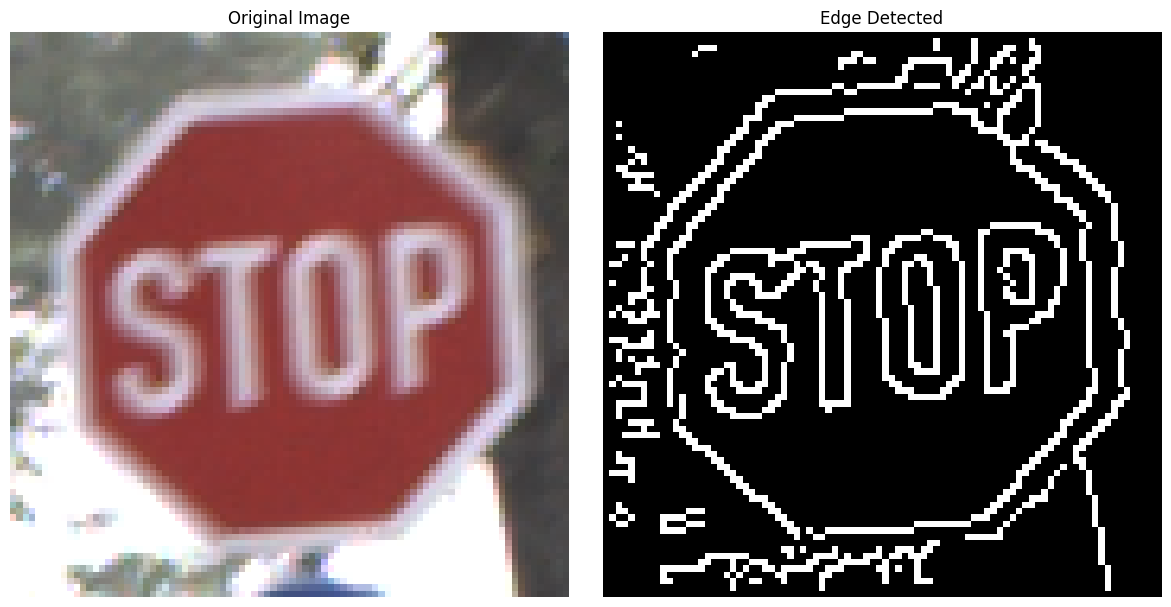

In [54]:

def canny_numpy(image):
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)  

    G, theta = sobel_gradient(image)
    nms = non_max_suppression(G, theta)
    dt, weak, strong = double_threshold(nms)
    edges = hysteresis(dt, weak, strong)
    return edges


# Get edges using your Canny implementation
edges = canny_numpy(image_rgb)

# Display original and edges side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_rgb.astype(np.uint8))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Edge Detected")
plt.imshow(edges.astype(np.uint8), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## Geometric Normalization

### Rotate the sign to an upright orientation

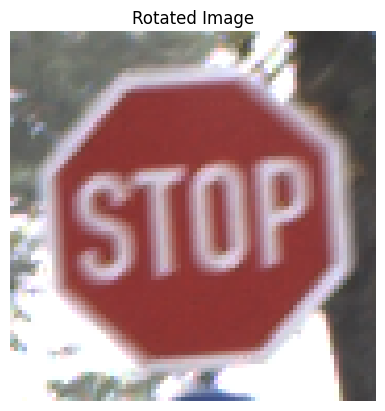

In [55]:
import numpy as np

def rotate_image_numpy(image, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)

    H, W = image.shape[:2]
    cx, cy = W / 2, H / 2

    # Output image same size as input
    if len(image.shape) == 2:
        rotated = np.zeros((H, W), dtype=np.uint8)
    else:
        rotated = np.zeros((H, W, image.shape[2]), dtype=np.uint8)

    # Inverse mapping: target → source
    for y in range(H):
        for x in range(W):
            # Translate to center, rotate, then back
            xt = x - cx
            yt = y - cy
            src_x = cos_a * xt + sin_a * yt + cx
            src_y = -sin_a * xt + cos_a * yt + cy

            src_x_int = int(round(src_x))
            src_y_int = int(round(src_y))

            if 0 <= src_x_int < W and 0 <= src_y_int < H:
                rotated[y, x] = image[src_y_int, src_x_int]

    return rotated

rotated = rotate_image_numpy(image_rgb, angle_deg=0)

plt.title("Rotated Image")
plt.imshow(rotated.astype(np.uint8))
plt.axis('off')
plt.show()

### Scale to a fixed size (e.g., 200×200 pixels)

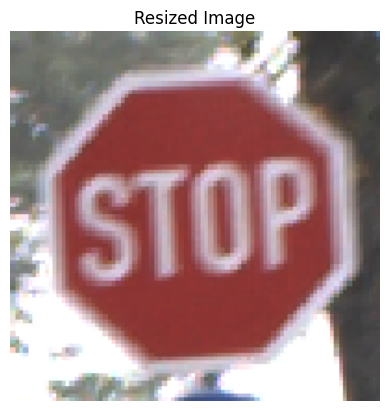

In [56]:
import numpy as np

def resize_image_numpy(image, new_size=(200, 200)):
    new_h, new_w = new_size
    old_h, old_w = image.shape[:2]

    scale_y = old_h / new_h
    scale_x = old_w / new_w

    if len(image.shape) == 2:
        resized = np.zeros((new_h, new_w), dtype=np.uint8)
    else:
        resized = np.zeros((new_h, new_w, image.shape[2]), dtype=np.uint8)

    for y in range(new_h):
        for x in range(new_w):
            src_y = int(y * scale_y)
            src_x = int(x * scale_x)
            resized[y, x] = image[src_y, src_x]

    return resized

resized = resize_image_numpy(image_rgb, new_size=(200, 200))
plt.title("Resized Image")
plt.imshow(resized.astype(np.uint8))
plt.axis('off')
plt.show()

###  Apply a perspective transform

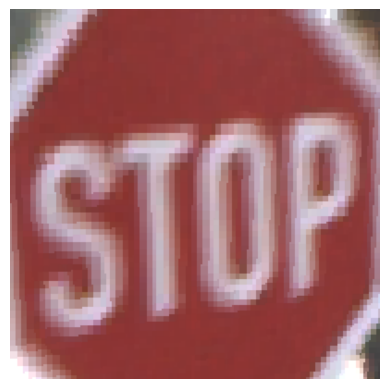

In [57]:
def compute_homography(src_pts, dst_pts):
    A = []
    for (x, y), (u, v) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))
    return H / H[2, 2]  

def warp_perspective(image, H, output_size=(200, 200)):
    H_inv = np.linalg.inv(H)
    H_out, W_out = output_size

    if len(image.shape) == 2:
        warped = np.zeros((H_out, W_out), dtype=np.uint8)
    else:
        warped = np.zeros((H_out, W_out, image.shape[2]), dtype=np.uint8)

    for y in range(H_out):
        for x in range(W_out):
            p = np.array([x, y, 1])
            p_src = H_inv @ p
            p_src /= p_src[2]
            sx, sy = p_src[0], p_src[1]
            sx, sy = int(round(sx)), int(round(sy))

            if 0 <= sx < image.shape[1] and 0 <= sy < image.shape[0]:
                warped[y, x] = image[sy, sx]

    return warped

src_pts = np.array([
    [30, 40],   # Top-left
    [170, 35],  # Top-right
    [180, 160], # Bottom-right
    [25, 150]   # Bottom-left
])

dest_pts = np.array([
    [0, 0],
    [199, 0],
    [199, 199],
    [0, 199]
])

H = compute_homography(src_pts, dest_pts)
normalized = warp_perspective(resized, H, output_size=(200, 200))

plt.imshow(normalized.astype(np.uint8))
plt.axis('off')
plt.show()

## Feature Extraction

### Corner Count (via Harris Corner Detection)

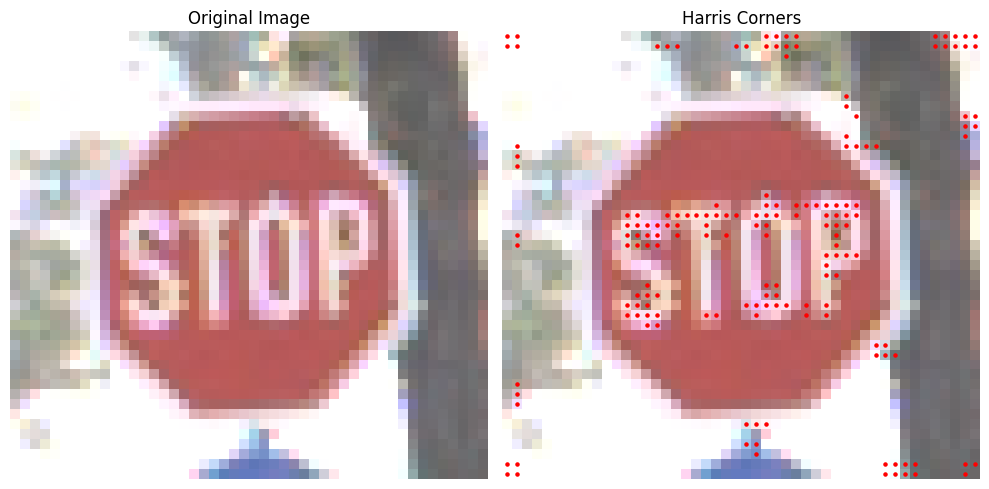

In [58]:
def harris_corner_detection_numpy(image, window_size=3, k=0.04, threshold=0.01):
  
    # Convert to grayscale if the image is in RGB
    if len(image.shape) == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image

    # Compute gradients using Sobel operator
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Ix = convolve2d(gray, sobel_x)
    Iy = convolve2d(gray, sobel_y)

    # Compute products of derivatives
    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy

    # Apply Gaussian filter to smooth the products
    gaussian_kernel = np.ones((window_size, window_size)) / (window_size ** 2)
    Sxx = convolve2d(Ixx, gaussian_kernel)
    Syy = convolve2d(Iyy, gaussian_kernel)
    Sxy = convolve2d(Ixy, gaussian_kernel)

    # Compute Harris response
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    R = det_M - k * (trace_M ** 2)

    # Threshold the response
    max_response = np.max(R)
    corners = R > threshold * max_response

    return corners

def convolve2d(image, kernel):
 
    kernel = np.flipud(np.fliplr(kernel))  # Flip the kernel
    output = np.zeros_like(image, dtype=np.float32)
    padded_image = np.pad(image, ((kernel.shape[0] // 2, ), (kernel.shape[1] // 2, )), mode='constant')

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            output[i, j] = np.sum(region * kernel)

    return output

# Example usage
image_path = sample_image_path
image = plt.imread(image_path)  # Load image using matplotlib

# Detect corners
corners = harris_corner_detection_numpy(image)

# Visualize the corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Harris Corners")
plt.imshow(image, cmap='gray')
plt.scatter(np.where(corners)[1], np.where(corners)[0], c='red', s=5)
plt.axis('off')

plt.tight_layout()
plt.show()

### Circularity C = $\frac{4\pi \times \text{Area}}{\text{Perimeter}^2}$

In [59]:
import numpy as np

def calculate_circularity(binary_mask):
    # Calculate the area (number of pixels in the object)
    area = np.sum(binary_mask)

    # Calculate the perimeter using a simple 8-connected neighborhood
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    perimeter = 0
    for i in range(1, padded_mask.shape[0] - 1):
        for j in range(1, padded_mask.shape[1] - 1):
            if padded_mask[i, j] == 1:
                # Check the 8 neighbors
                neighbors = padded_mask[i-1:i+2, j-1:j+2]
                perimeter += 8 - np.sum(neighbors)

    # Calculate circularity
    if perimeter == 0:  # Avoid division by zero
        return 0
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

# Example usage
binary_mask = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0]
])

binary_mask_edges = edges.astype(np.uint8)
binary_mask_edges[binary_mask_edges == 255] = 1
circularity = calculate_circularity(binary_mask_edges)
print(f"Circularity: {circularity}")

Circularity: 0.0006002048481950622


### Aspect Ratio (width/height of bounding box)

In [60]:
def calculate_aspect_ratio(binary_mask):
    """
    Calculate the aspect ratio (width/height) of the bounding box of an object in a binary mask.

    Parameters:
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - aspect_ratio: The aspect ratio (float).
    """
    # Find the coordinates of the non-zero pixels
    rows, cols = np.where(binary_mask == 1)

    # Calculate the bounding box dimensions
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1

    # Calculate aspect ratio
    aspect_ratio = width / height
    return aspect_ratio



### Extent (ratio of region area to bounding box area)

In [61]:
def calculate_extent(binary_mask):
    """
    Calculate the extent (ratio of region area to bounding box area) of an object in a binary mask.

    Parameters:
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - extent: The extent value (float).
    """
    # Calculate the area of the object
    area = np.sum(binary_mask)

    # Find the coordinates of the non-zero pixels
    rows, cols = np.where(binary_mask == 1)

    # Calculate the bounding box dimensions
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1

    # Calculate the bounding box area
    bounding_box_area = width * height

    # Calculate extent
    extent = area / bounding_box_area
    return extent



### Average Hue

In [62]:
def calculate_average_hue(image, binary_mask):
    """
    Calculate the average hue of an object in an image using a binary mask.

    Parameters:
    - image: An RGB image (numpy array).
    - binary_mask: A binary image (numpy array) where the object is represented by 1s and the background by 0s.

    Returns:
    - average_hue: The average hue value (float).
    """
    # Convert the image to HSV
    hsv_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j] / 255.0
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min

            # Hue calculation
            if delta == 0:
                h = 0
            elif c_max == r:
                h = (60 * ((g - b) / delta) + 360) % 360
            elif c_max == g:
                h = (60 * ((b - r) / delta) + 120) % 360
            else:
                h = (60 * ((r - g) / delta) + 240) % 360

            hsv_image[i, j, 0] = h

    # Extract the hue values where the binary mask is 1
    hue_values = hsv_image[:, :, 0][binary_mask == 1]

    # Calculate the average hue
    average_hue = np.mean(hue_values)
    return average_hue


In [63]:
# Example usage
binary_mask = np.array([
    [0, 0, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0]
])

image = np.random.randint(0, 255, (5, 6, 3), dtype=np.uint8)  # Example RGB image

aspect_ratio = calculate_aspect_ratio(binary_mask_edges)
extent = calculate_extent(binary_mask_edges)
average_hue = calculate_average_hue(image_rgb, binary_mask_edges)

print(f"Aspect Ratio: {aspect_ratio}")
print(f"Extent: {extent}")
print(f"Average Hue: {average_hue}")

Aspect Ratio: 0.9425287356321839
Extent: 0.16358284272497897
Average Hue: 204.28176879882812


##  Rule-Based Classification 

In [149]:
import numpy as np

def extract_features(image, binary_mask):
    """
    Extract features from an image and its binary mask.

    Parameters:
    - image: An RGB image (numpy array of shape (height, width, 3)).
    - binary_mask: A binary image (numpy array of shape (height, width)) where the object is 1s and background is 0s.

    Returns:
    - features: A dictionary containing extracted features.
    """
    # Calculate aspect ratio
    rows, cols = np.where(binary_mask == 1)
    if len(rows) == 0 or len(cols) == 0:  # Handle empty mask
        return {'color': 'unknown', 'corner_count': 0, 'circularity': 0, 'aspect_ratio': 0, 'extent': 0, 'avg_hue': 0}
    width = cols.max() - cols.min() + 1
    height = rows.max() - rows.min() + 1
    aspect_ratio = width / height if height != 0 else 0

    # Calculate extent
    area = np.sum(binary_mask)
    bounding_box_area = width * height
    extent = area / bounding_box_area if bounding_box_area != 0 else 0

    # Calculate circularity
    padded_mask = np.pad(binary_mask, pad_width=1, mode='constant', constant_values=0)
    perimeter = 0
    for i in range(1, padded_mask.shape[0] - 1):
        for j in range(1, padded_mask.shape[1] - 1):
            if padded_mask[i, j] == 1:
                neighbors = padded_mask[i-1:i+2, j-1:j+2]
                perimeter += 8 - np.sum(neighbors)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

    # Calculate average hue
    hsv_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r, g, b = image[i, j] / 255.0
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min
            if delta == 0:
                h = 0
            elif c_max == r:
                h = (60 * ((g - b) / delta) + 360) % 360
            elif c_max == g:
                h = (60 * ((b - r) / delta) + 120) % 360
            else:
                h = (60 * ((r - g) / delta) + 240) % 360
            hsv_image[i, j, 0] = h
    hue_values = hsv_image[:, :, 0][binary_mask == 1]
    avg_hue = np.mean(hue_values) if len(hue_values) > 0 else 0

    # Harris corner detection (simplified version from notebook)
    def harris_corner_detection_numpy(img):
        img_gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])  # Convert to grayscale
        I_x = np.gradient(img_gray, axis=1)
        I_y = np.gradient(img_gray, axis=0)
        Ixx = I_x ** 2
        Iyy = I_y ** 2
        Ixy = I_x * I_y
        window_size = 3
        gaussian_kernel = np.ones((window_size, window_size)) / (window_size ** 2)
        Sxx = convolve2d(Ixx, gaussian_kernel)
        Syy = convolve2d(Iyy, gaussian_kernel)
        Sxy = convolve2d(Ixy, gaussian_kernel)
        det_M = (Sxx * Syy) - (Sxy ** 2)
        trace_M = Sxx + Syy
        k = 0.04
        R = det_M - k * (trace_M ** 2)
        threshold = 0.01
        max_response = np.max(R) if np.max(R) > 0 else 1
        corners = R > threshold * max_response
        return corners

    def convolve2d(image, kernel):
        kernel = np.flipud(np.fliplr(kernel))
        output = np.zeros_like(image, dtype=np.float32)
        padded_image = np.pad(image, ((kernel.shape[0] // 2, ), (kernel.shape[1] // 2, )), mode='constant')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded_image[i:i+kernel.shape[0], j:j+kernel.shape[1]]
                output[i, j] = np.sum(region * kernel)
        return output

    corners = harris_corner_detection_numpy(image)
    corner_count = np.sum(corners)

    # Determine dominant color
    red_segment = np.all(image > [150, 0, 0], axis=-1) & np.any(image < [255, 100, 100], axis=-1)  # Rough red detection
    blue_segment = np.all(image > [0, 0, 150], axis=-1) & np.any(image < [100, 100, 255], axis=-1)  # Rough blue detection
    yellow_segment = np.all(image > [150, 150, 0], axis=-1) & np.any(image < [255, 255, 100], axis=-1)  # Rough yellow detection
    color = 'red' if np.sum(red_segment) > np.sum(blue_segment) and np.sum(red_segment) > np.sum(yellow_segment) else \
            'blue' if np.sum(blue_segment) > np.sum(red_segment) and np.sum(blue_segment) > np.sum(yellow_segment) else \
            'yellow' if np.sum(yellow_segment) > np.sum(red_segment) and np.sum(yellow_segment) > np.sum(blue_segment) else 'unknown'

    return {
        'color': color,
        'corner_count': corner_count,
        'circularity': circularity,
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'avg_hue': avg_hue
    }

def rule_based_classifier(image, binary_mask):
    """
    Classify traffic signs based on extracted features using rule-based logic.

    Parameters:
    - image: An RGB image (numpy array of shape (height, width, 3)).
    - binary_mask: A binary image (numpy array of shape (height, width)) where the object is 1s and background is 0s.

    Returns:
    - class_id: Predicted class ID of the traffic sign (-1 if unknown).
    """
    # Extract features
    features = extract_features(image, binary_mask)

    # Rule-based classification logic
    if features['color'] == 'red':
        if features['corner_count'] == 8:  # Octagonal shape for Stop sign
            return 14  # Stop (ClassId 14)
        elif features['circularity'] > 0.8 and features['aspect_ratio'] < 1.2:  # Circular shape for Speed Limit
            return 0  # Speed Limit 20 (ClassId 0)
        elif features['aspect_ratio'] > 2 and features['extent'] < 0.5:  # Elongated shape for No Entry
            return 17  # No Entry (ClassId 17)
        elif features['corner_count'] > 4:  # Multiple corners for No Overtaking
            return 9  # No Overtaking (ClassId 9)

    elif features['color'] == 'yellow':
        if features['corner_count'] == 3:  # Triangular shape for Pedestrian Crossing
            return 27  # Pedestrian Crossing (ClassId 27)

    elif features['color'] == 'blue':
        if features['circularity'] > 0.8 and features['aspect_ratio'] < 1.2:  # Circular shape for Go Right
            return 33  # Go Right (ClassId 33)
        elif features['corner_count'] > 4:  # Multiple arrows for Roundabout
            return 40  # Roundabout (ClassId 40)

    # Default case for Priority Road (ClassId 12) or unknown
    if features['extent'] > 0.7 and features['aspect_ratio'] > 1.5:  # Elongated with high coverage
        return 12  # Priority Road (ClassId 12)
    return -1  # Unknown class


In [154]:
image_path = "archive/Train/12/00012_00000_00025.png"
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

edges = canny_numpy(image_rgb)
binary_mask_edges = edges.astype(np.uint8)
binary_mask_edges[binary_mask_edges == 255] = 1

predicted_class = rule_based_classifier(image_rgb, binary_mask_edges)
print(f"Predicted Class: {predicted_class}")

Predicted Class: 9


In [155]:
extract_features(image_rgb, binary_mask_edges)

{'color': 'red',
 'corner_count': 180,
 'circularity': 0.0011695814455092845,
 'aspect_ratio': 0.9629629629629629,
 'extent': 0.24180911680911682,
 'avg_hue': 103.266914}

In [ ]:
def calculate_average_features(features_list):
    """
    Calculate the average of numerical features from a list of feature dictionaries.
    String features are excluded from averaging.

    Parameters:
    - features_list: A list of dictionaries where each dictionary contains features.

    Returns:
    - average_features: A dictionary containing the average of numerical features.
    """
    # Initialize a dictionary to store the sum of each feature
    feature_sums = {}
    num_features = len(features_list)

    # Iterate through the list of features
    for features in features_list:
        for key, value in features.items():
            # Skip string features
            if isinstance(value, str):
                continue
            if key not in feature_sums:
                feature_sums[key] = 0
            feature_sums[key] += value

    # Calculate the average for each numerical feature
    average_features = {key: value / num_features for key, value in feature_sums.items()}

    # Add string features (e.g., 'color') as they are (e.g., the first occurrence)
    for key, value in features_list[0].items():
        if isinstance(value, str):
            average_features[key] = value

    return average_features


Average Features for Class 14:
corner_count: 297.0733333333333
circularity: 0.0022040483766588553
aspect_ratio: 0.9582736671330284
extent: 0.2425426997106787
avg_hue: 125.09219652811686
color: red


##  Evaluation